In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import os
import seaborn as sns

In [2]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging
from ema_workbench import MultiprocessingEvaluator

from ema_workbench.analysis import parcoords

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

"""
    Parameters
    ----------
    problem_formulation_id : int {0, ..., 6}
                             problem formulations differ with respect to the objectives
                             0: Total cost, and casualties
                             1: Expected damages, costs, and casualties
                             2: expected damages, dike investment costs, rfr costs, evacuation cost, and casualties
                             3: costs and casualties disaggregated over dike rings, and room for the river and evacuation costs
                             4: Expected damages, dike investment cost and casualties disaggregated over dike rings and room for the river and evacuation costs
                             5: disaggregate over time and space
                             6: Same as 3 but only aggregated for Gelderland, NOTE Expected annual damage only represents Gelderland

    """
problem_formulation = 6  # Change this to the desired problem formulation ID
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation)

In [4]:
for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)


CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [5]:
from ema_workbench import ScalarOutcome, Scenario

# List of outcomes you want to optimize
objectives = ['Expected Annual Damage', 'Expected Number of Deaths']

# # Loop over all outcomes
# for outcome in dike_model.outcomes:
#     if outcome.name in objectives:
#         outcome.kind = ScalarOutcome.MINIMIZE 
#     else:
#         outcome.kind = ScalarOutcome.INFO  # neutral, will be ignored in optimization


for outcome in dike_model.outcomes:
    print(f"{outcome.name}: kind={outcome.kind}")

reference_scenario = Scenario('Reference Scenario', **dict({
    'discount rate 0': 2.5,
    'discount rate 1': 2.5,
    'discount rate 2': 2.5,
    'A.0_ID flood wave shape': 4,
    'A.1_Bmax': 175,
    'A.2_Bmax': 175,
    'A.3_Bmax': 175,
    'A.4_Bmax': 175,
    'A.5_Bmax': 175,
    'A.1_pfail': 0.5,
    'A.2_pfail': 0.5,
    'A.3_pfail': 0.5,
    'A.4_pfail': 0.5,
    'A.5_pfail': 0.5,
    'A.1_Brate': 1.5,
    'A.2_Brate': 1.5,
    'A.3_Brate': 1.5,
    'A.4_Brate': 1.5,
    'A.5_Brate': 1.5
}))



A.1 Total Costs: kind=-1
A.1_Expected Number of Deaths: kind=-1
A.2 Total Costs: kind=-1
A.2_Expected Number of Deaths: kind=-1
A.3 Total Costs: kind=-1
A.3_Expected Number of Deaths: kind=-1
Expected Evacuation Costs: kind=-1
Expected Annual Damage: kind=-1
Expected Number of Deaths: kind=-1


In [40]:
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress
convergence_metrics = [
    ArchiveLogger('./data/test_runs', [l.name for l in dike_model.levers],
                  [o.name for o in dike_model.outcomes],
                  base_filename='pf6_run.tar.gz'),
    EpsilonProgress()
]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results1, convergence = evaluator.optimize(nfe=100, searchover='levers',  epsilons=[0.5,]*len(dike_model.outcomes), reference=reference_scenario,convergence=convergence_metrics)

[MainProcess/INFO] pool started with 12 workers
100%|████████████████████████████████████████| 100/100 [00:11<00:00,  8.46it/s]
[MainProcess/INFO] optimization completed, found 22 solutions
[MainProcess/INFO] terminating pool


In [23]:
results1

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 2,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,Expected Evacuation Costs,Expected Annual Damage,Expected Number of Deaths
0,0,0,1,1,0,1,1,1,1,0,...,7,2.634115e+08,0.0,1.408227e+08,0.000000,9.970639e+07,0.000000,0.000000,0.000000e+00,0.000000
1,0,1,1,1,1,0,0,1,0,0,...,7,3.269490e+07,0.0,1.594429e+08,0.000000,7.496633e+07,0.001680,223.618518,6.422795e+06,0.001680
2,1,1,1,1,1,1,1,0,1,1,...,4,1.254751e+08,0.0,1.479297e+08,0.000000,1.074125e+08,0.000000,0.000000,0.000000e+00,0.000000
3,1,1,0,1,1,0,1,0,1,1,...,3,1.654517e+08,0.0,1.726339e+07,0.015721,1.367986e+08,0.000000,0.000000,1.726339e+07,0.015721
4,1,1,1,1,1,0,1,0,0,1,...,4,9.510733e+07,0.0,1.621916e+08,0.000000,9.010681e+07,0.000188,88.852403,9.011732e+05,0.000188
5,0,0,1,1,0,0,1,1,0,0,...,0,1.208728e+08,0.0,1.824515e+08,0.000000,5.569023e+07,0.000000,0.000000,0.000000e+00,0.000000
6,0,1,0,1,0,1,1,1,1,1,...,3,3.266304e+08,0.0,2.815245e+08,0.000000,2.216782e+07,0.000000,387.721900,0.000000e+00,0.000000
7,0,1,0,1,1,0,1,1,1,0,...,9,1.688259e+08,0.0,1.584478e+08,0.000000,7.752567e+07,0.000000,0.000000,0.000000e+00,0.000000
8,1,1,1,0,0,1,0,1,0,1,...,7,3.568819e+08,0.0,1.099569e+08,0.001151,6.543735e+07,0.000000,948.325227,3.409882e+06,0.001151
9,0,0,0,0,1,1,1,0,0,0,...,2,2.940311e+08,0.0,1.153973e+08,0.001747,9.799391e+07,0.000000,840.313521,1.587194e+07,0.001747


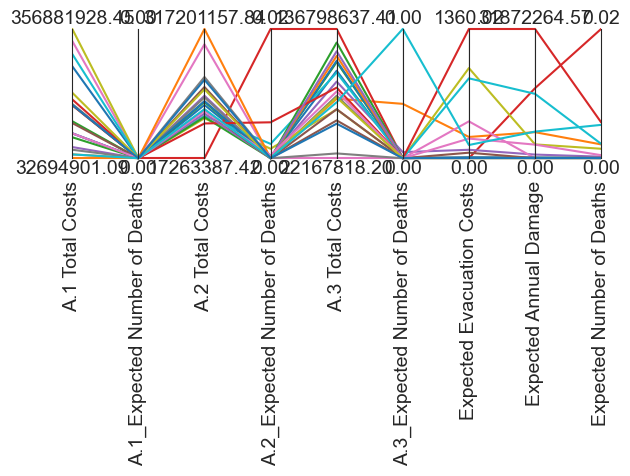

In [24]:
data = results1.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

C:\Users\sweja\PycharmProjects\Model-based\.venv\Lib\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


<Figure size 3000x3000 with 0 Axes>

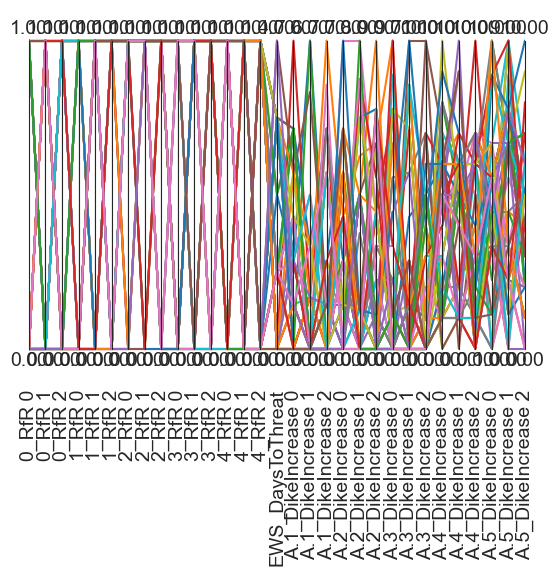

In [17]:
data2 = results1.loc[:, [o.name for o in dike_model.levers]]
limits2 = parcoords.get_limits(data2)
plt.figure(figsize=(30, 30))
paraxes = parcoords.ParallelAxes(limits2)
paraxes.plot(data2)

plt.show()

In [47]:
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import epsilon_nondominated,to_problem
# archive = ArchiveLogger.load_archives('./data/test_runs/pf6_run.tar.gz')
all_archives = []

for i in range(1):
    archives = ArchiveLogger.load_archives('./data/test_runs/pf6_run.tar.gz')
    sample_archive = list(archives.values())[0]  # pak 1e NFE-waarde
    print(sample_archive.columns)
    all_archives.append(archives)
problem = to_problem(dike_model, searchover="levers")
results = [results1]
reference_set = epsilon_nondominated(results, [0.5] * len(dike_model.outcomes), problem)

hv = HypervolumeMetric(reference_set, problem)
gd = GenerationalDistanceMetric(reference_set, problem, d=1)
ei = EpsilonIndicatorMetric(reference_set, problem)
ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
sm = SpacingMetric(problem)

metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_by_seed.append(metrics)

Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'Expected Evacuation Costs',
       'Expected Annual Damage', 'Expected Number of Deaths'],
      dtype='object')


EMAError: Parameter names ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'] not found in archive